###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

2024-05-26 16:05:44.406685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(1337)
random.seed(1337)

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

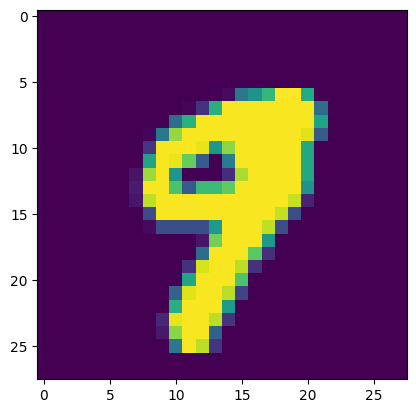

In [5]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [6]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(y, classes):
    NEG = -1.0
    GREY = 0.0
    POS = 1.0

    noise = np.array([GREY] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decode(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    return oh_decode, np.array([oh_enc[cls] for cls in y])

OH_DECODER, Y_oh = oh_encode(Y_train, POSITIVE_CLASSES)
Y_oh.shape

(60000, 10)

In [7]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [8]:
def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return loss(scores, expected), accuracy(scores, expected)

In [9]:
# initialize a model
model = MLP(
    784,
    [
        (10, 'squeeze')
    ],
    lr=1.0
)
print(model)
print("number of parameters", len(model.parameters()))

ALL_SAMPLES = None

MLP of [Layer of [squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784), squeeze-Neuron(784)]]
number of parameters 7850


In [10]:
# train the model
BATCH_SIZE = 1
X_b, Y_b = get_batch(X_train, Y_oh, BATCH_SIZE)
X_b.shape

[OH_DECODER(vs) for vs in arr2vals(Y_b, 'expected')]


[6]

In [11]:
if ALL_SAMPLES is None:
    ALL_SAMPLES = X_b
else:
    ALL_SAMPLES = np.concatenate([ALL_SAMPLES, X_b])

In [12]:
ITERATIONS = 25

# optimization loop
for k in range(ITERATIONS):
    total_loss, acc = evaluate(model, X_b, Y_b)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    if total_loss.data == 0:
        print("Early stop!")
        break

    model.learn_from(total_loss, q=0.75)

total_loss, acc = evaluate(model, X_b, Y_b)
print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 16.0, accuracy 0.0%
step 1 loss 0.0, accuracy 100.0%
Early stop!
step 1 loss 0.0, accuracy 100.0%
final loss 0.0, accuracy 100.0%


# DEBUG

In [13]:
input = arr2vals(X_b, 'input')
expected = arr2vals(Y_b, 'expected')
scores = feed_forward(model, input)

for a, e in zip(scores, expected):
    op = '=' if a == e else '!='
    print(f'actual: {OH_DECODER(a)} {op} expected: {OH_DECODER(e)}')

actual: 6 != expected: 6


In [194]:
scores

[[Value(auto : [-0.9999999588942899, 8.221142011599625e-08]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-0.99999938613373, -3.99999877226746]),
  Value(auto : [-0.9999999999999696, 6.084022174945858e-14]),
  Value(auto : [-1.0, 0]),
  Value(auto : [-0.9999975396382422, 4.920723515544623e-06])]]

In [187]:
expected

[[Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0]),
  Value(expected : [-1.0, 0])]]

In [193]:
total_loss = loss(scores, expected)
total_loss.backward()
total_loss, [p for p in model.parameters() if p.grad > 0.0]

(Value(auto : [3.999997544541352, 1]),
 [Value(weight : [-0.30063609314541634, 1.453741093135028e-16]),
  Value(weight : [0.9350614727992229, 1.453741093135028e-16]),
  Value(weight : [0.48819454862856776, 1.453741093135028e-16]),
  Value(weight : [-0.12929421129141414, 1.453741093135028e-16]),
  Value(weight : [0.7076552927613854, 1.453741093135028e-16]),
  Value(weight : [-0.9647878400862934, 1.453741093135028e-16]),
  Value(weight : [-0.5082370492636189, 1.453741093135028e-16]),
  Value(weight : [-0.032177077897089755, 1.453741093135028e-16]),
  Value(weight : [-0.11357997302999043, 1.453741093135028e-16]),
  Value(weight : [-0.14055707025119443, 1.453741093135028e-16]),
  Value(weight : [0.48521200012393156, 1.453741093135028e-16]),
  Value(weight : [-0.43709188577742947, 1.453741093135028e-16]),
  Value(weight : [-0.632787852831236, 1.453741093135028e-16]),
  Value(weight : [-0.427167955146914, 1.453741093135028e-16]),
  Value(weight : [0.7239830574419387, 1.453741093135028e-16]),